# What is a Generative Adversarial Networks (GAN)



GAN is a class of machine learning model that uses two different neural network. 
<br>
-One Generator train to generate new samples.
<br>
-One Discriminator train to classify a sample as Real (image from dataset) or Fake (Image generated with the generator).
<br>
These two models are trained together until the discriminator is fooled about half the time, which mean the new sample creatted by the generator can be classify as "Real" 

![Inlet Spike](assets/gan2.png)

## How GAN works
First, the Generator takes as input a random vector of fixed size (latent variable) and output an images, it learn by tricking the Discriminator.
<br>
Then, the Discrimitor learn to distinguish between Real and Fake images. To do so, it learn pattern and features from the images and once it is trained, it tries to identify these features in the image given as input. 

## GAN Process

**STEP 1**: Generate latent variable (noise vector).
<br>
**STEP 2**: Give the vector to the Generator to create fake images.
<br>
**STEP 3**: Sample Real and Fake images
<br>
**STEP 4**: Train Discriminator with the mixed set
<br>
**STEP 5**: Generate fake images but lebelled them as Real
<br>
**STEP 6**: Train GAN using noise vectore labeled as real images

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, ReLU, LeakyReLU, Reshape, Conv2DTranspose
import PIL
from numba import jit, njit, vectorize, cuda, uint8, f8, uint32
import matplotlib.pyplot as plt
from IPython import display
import os
import glob
from sklearn.utils import shuffle
from tqdm.notebook import tqdm


## GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset 

The GAN will be trained by using Stanfords Dogs datasat which is composed of about 20000 images and 120 breeds of dogs.

In [3]:
def load_images(main_folder="./Images", target_size=(64, 64)):
    images = []
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        image_paths = glob.glob(subfolder_path + '/*.[jJ][pP][gG]')
        for image_path in image_paths:
            image = PIL.Image.open(image_path)
            image = image.resize(target_size)
            image = np.array(image)
            images.append(image)
    
    np_images = np.array(images)
    return np_images

<function matplotlib.pyplot.show(close=None, block=None)>

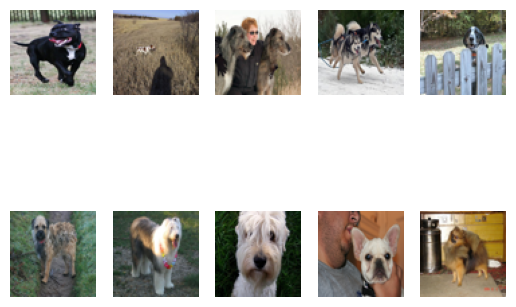

In [4]:
images_size = (64, 64)
batch_size = 32
images = load_images()
images = shuffle(images, random_state=42)
train_dataset = (images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(20580).batch(batch_size)

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(0, len(images))
    plt.axis('off')
    plt.imshow(images[random_index])
plt.show


## Generator Model

In [5]:
def create_model_generator():
    model = Sequential()
    
    model.add(Reshape((1, 1, 100), input_shape=(100,)))

    #assert model.output_shape == (None, 1, 1, 100)

    model.add(Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid'))
    #assert model.output_shape == (None, 4, 4, 512)
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
    #assert model.output_shape == (None, 8, 8, 256)
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    #assert model.output_shape == (None, 16, 16, 128)
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    #assert model.output_shape == (None, 32, 32, 64)
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same'))
    #assert model.output_shape == (None, 64, 64, 3)
    model.add(Activation('tanh'))  

    return model


In [6]:


def create_model_discriminator():
    model = Sequential()
    
    # 3x64x64 -> 64x32x32
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    
    # 64x32x32 -> 128x16x16
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # 128x16x16 -> 256x8x8
    model.add(Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (4, 4), strides=(1, 1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) 

    #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [7]:
#generator = create_model_generator()
#discriminator = create_model_discriminator()

generator_opti = tf.keras.optimizers.Adam(0.001)
discriminator_opti = tf.keras.optimizers.Adam(0.0005)


In [8]:
epochs = 100

In [12]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)


In [13]:
def train_step(images, generator, discriminator):
    noises = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noises, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_opti.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_opti.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
def train(dataset, epochs, generator, discriminator):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator)
            print(f'[{epoch + 1}/{epochs}][{i + 1}/{len(train_dataset)}] Loss_D: {disc_loss.numpy():.4f} Loss_G: {gen_loss.numpy():.4f}')
        print(f'Epoch {epoch + 1} done')

In [15]:
gen_test = create_model_generator()
disc_test = create_model_discriminator()
train(train_dataset, epochs, gen_test, disc_test)

[1/100][51/644] Loss_D: 1.8545 Loss_G: 0.4605
[1/100][51/644] Loss_D: 5.7731 Loss_G: 25.7162
[1/100][51/644] Loss_D: 25.2237 Loss_G: 0.0000
[1/100][51/644] Loss_D: 4.5637 Loss_G: 43.4555
[1/100][51/644] Loss_D: 4.1842 Loss_G: 24.7037
[1/100][51/644] Loss_D: 10.9046 Loss_G: 0.1357
[1/100][51/644] Loss_D: 3.3803 Loss_G: 7.8874
[1/100][51/644] Loss_D: 2.7795 Loss_G: 9.3451
[1/100][51/644] Loss_D: 4.6394 Loss_G: 2.4663
[1/100][51/644] Loss_D: 4.5559 Loss_G: 3.6481
[1/100][51/644] Loss_D: 1.4319 Loss_G: 8.7957
[1/100][51/644] Loss_D: 0.8491 Loss_G: 9.9351
[1/100][51/644] Loss_D: 0.8985 Loss_G: 5.8662
[1/100][51/644] Loss_D: 2.5370 Loss_G: 0.9043
[1/100][51/644] Loss_D: 1.5718 Loss_G: 6.4034
[1/100][51/644] Loss_D: 0.8011 Loss_G: 5.8116
[1/100][51/644] Loss_D: 3.0400 Loss_G: 2.2129
[1/100][51/644] Loss_D: 0.7000 Loss_G: 5.1115
[1/100][51/644] Loss_D: 1.3990 Loss_G: 7.7057
[1/100][51/644] Loss_D: 1.4787 Loss_G: 8.3322
[1/100][51/644] Loss_D: 0.8216 Loss_G: 7.7846
[1/100][51/644] Loss_D: 0.202

KeyboardInterrupt: 

In [11]:
import ipywidgets 

def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)


binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#generator_loss = []
#discriminator_loss = []
generator_TEST = create_model_generator()
discriminator = create_model_discriminator()

for epoch in range(epochs):
    for i, real_images in tqdm(enumerate(train_dataset), total=len(train_dataset)):

        noises = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator_TEST(noises, training=True)

            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(fake_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output) 
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator_TEST.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_opti.apply_gradients(zip(gradients_of_generator, generator_TEST.trainable_variables))
        discriminator_opti.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        if (i+1) % (len(train_dataset)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, i+1, len(train_dataset),
                     gen_loss, disc_loss))


  0%|          | 0/644 [00:00<?, ?it/s]

c:\Users\Hugo\anaconda3\envs\pygpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


[1/100][322/644] Loss_D: 3.5672 Loss_G: 0.0589
[1/100][644/644] Loss_D: 6.3587 Loss_G: 0.0024


  0%|          | 0/644 [00:00<?, ?it/s]

[2/100][322/644] Loss_D: 7.7140 Loss_G: 0.0005
[2/100][644/644] Loss_D: 9.7985 Loss_G: 0.0001


  0%|          | 0/644 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('generator.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck



NameError: name 'generate_latent_points' is not defined